# Desenvolvimento - TCC Engenharia de Software

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-06-05 18:30:11.135798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEED = 42
BATCH_SIZE = 32
ROOT = 'data'
X = 'path'
Y = 'target'
PRED = 'pred'
PRED_PROBA = 'pred_proba'
PRED_CLASS = 'pred_class'
MODEL_PATH = './model'

## 1. Load data

In [3]:
train_path = list(Path(f'{ROOT}/train').glob(r'**/*.jpeg'))
val_path = list(Path(f'{ROOT}/val').glob(r'**/*.jpeg'))
test_path = list(Path(f'{ROOT}/test').glob(r'**/*.jpeg'))

In [4]:
def load_df(path):
    targets = [str(path[i]).split('/')[-2] for i in range(len(path))]

    return pd.concat([
        pd.Series(path, name=X).astype('str'), 
        pd.Series(targets, name=Y)
    ], axis=1).sample(frac=1, random_state=SEED).reset_index(drop=True)


train_df = load_df(train_path)
val_df = load_df(val_path)
test_df = load_df(test_path)

train_df = pd.concat([train_df, val_df]).reset_index(drop=True)

print(train_df.shape)
print(test_df.shape)

CLASSES = sorted(train_df[Y].unique())
print(f'Classes (first is 0, second is 1): {CLASSES}')

train_df.head()

(5232, 2)
(624, 2)
Classes (first is 0, second is 1): ['NORMAL', 'PNEUMONIA']


,path,target
0,data/train/PNEUMONIA/person62_bacteria_303.jpeg,PNEUMONIA
1,data/train/PNEUMONIA/person669_bacteria_2562.jpeg,PNEUMONIA
2,data/train/NORMAL/NORMAL2-IM-0939-0001.jpeg,NORMAL
3,data/train/NORMAL/IM-0753-0001.jpeg,NORMAL
4,data/train/PNEUMONIA/person650_virus_1232.jpeg,PNEUMONIA


In [18]:
print(train_df[Y].value_counts() + test_df[Y].value_counts())

PNEUMONIA    4273
NORMAL       1583
Name: target, dtype: int64


### 1.1. Plot dataset samples

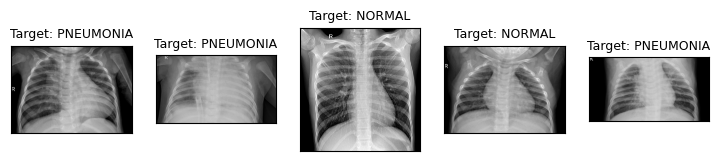

In [5]:
fig, axes = plt.subplots(ncols=5, figsize=(9, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df[X][i]), cmap='gray', vmin=0, vmax=255)
    ax.set_title(f'Target: {train_df[Y][i]}', fontsize=9)
    
plt.show()

## 2. Instantiate data generators

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    #validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input
)

train_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col=X,
    y_col=Y,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=SEED,
    subset='training'
)

# val_flow = train_generator.flow_from_dataframe(
#     dataframe=train_df,
#     x_col=X,
#     y_col=Y,
#     target_size=(224, 224),
#     batch_size=BATCH_SIZE,
#     seed=SEED,
#     subset='validation'
# )

test_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col=X,
    y_col=Y,
    classes=CLASSES,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5232 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## 3. Train models

In [7]:
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(224, 224, 3)
)
resnet.trainable = False
hidden_layer_1 = tf.keras.layers.Dense(256, activation='relu')(resnet.output)
hidden_layer_1 = tf.keras.layers.BatchNormalization()(hidden_layer_1)
hidden_layer_1 = tf.keras.layers.Dropout(0.3)(hidden_layer_1)
hidden_layer_2 = tf.keras.layers.Dense(128, activation='relu')(hidden_layer_1)
hidden_layer_2 = tf.keras.layers.BatchNormalization()(hidden_layer_2)
hidden_layer_2 = tf.keras.layers.Dropout(0.2)(hidden_layer_2)
output = tf.keras.layers.Dense(2, activation='softmax')(hidden_layer_2)
resnet = tf.keras.Model(inputs=resnet.input, outputs=output)

resnet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.AUC(curve='PR', name='pr_auc'),
        tf.keras.metrics.AUC(curve='ROC', name='roc_auc'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

resnet.fit(
    train_flow,
    #validation_data=val_flow, 
    epochs=1, 
    verbose=1
)

# tf.keras.saving.load_model(MODEL_PATH)

2023-06-05 18:30:16.144198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


164/164 [==============================] - 540s 3s/step - loss: 0.2206 - pr_auc: 0.9668 - roc_auc: 0.9720 - accuracy: 0.9312 - precision: 0.9312 - recall: 0.9312


### 3.1. Make predictions in the test subset

In [8]:
test_predictions = resnet.predict(test_flow)

test_df[PRED_PROBA] = test_predictions[:, 1]
test_df[PRED] = np.argmax(test_predictions, axis=1)
test_df[PRED_CLASS] = [CLASSES[y] for y in test_df[PRED].tolist()]

20/20 [==============================] - 67s 3s/step


## 4. Model validation

### 4.1. Confusion matrix

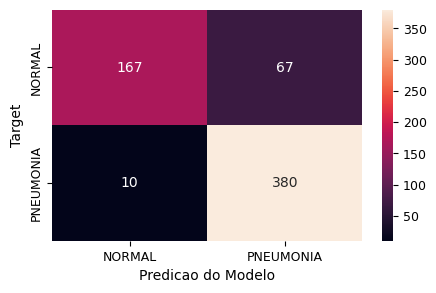

In [22]:
fig, axes = plt.subplots(figsize=(5, 3))

cm = confusion_matrix(test_df[Y], test_df[PRED_CLASS], labels=CLASSES)

axes.set_xlabel("Target", fontsize=8)
axes.set_ylabel("Predicao do Modelo", fontsize=8)

ax = sns.heatmap(cm, annot=True, fmt='d', annot_kws={'fontsize': 10})

ax.set_xlabel("Predicao do Modelo", fontsize=10)
ax.xaxis.set_ticklabels(CLASSES)
plt.xticks(fontsize=9, rotation=0)

ax.set_ylabel("Target", fontsize=10)
ax.yaxis.set_ticklabels(CLASSES)
plt.yticks(fontsize=9, rotation=90)

ax.collections[0].colorbar.ax.tick_params(labelsize=9)

plt.show()

### 4.3. Accuracy, Precision, Recall (sensitivity) and F1-Score

In [10]:
print(classification_report(test_df[Y], test_df[PRED_CLASS]))

              precision    recall  f1-score   support

      NORMAL       0.94      0.71      0.81       234
   PNEUMONIA       0.85      0.97      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



### 4.4. Specificity

In [14]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn+fp)

specificity

0.7136752136752137

### 4.5. Display a sample of predictions

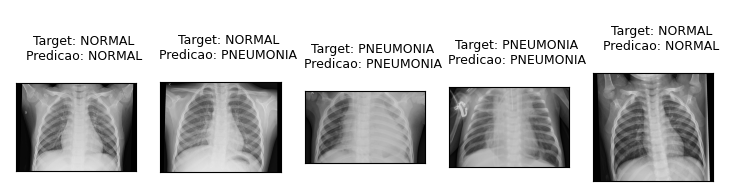

In [23]:
fig, axes = plt.subplots(ncols=5, figsize=(9, 5), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df[X].iloc[i]), cmap='gray', vmin=0, vmax=255)
    title = f'''
    Target: {test_df[Y].iloc[i]}
    Predicao: {test_df[PRED_CLASS].iloc[i]}
    '''
    ax.set_title(title, fontsize=9)

plt.show()

## 5. Save model

In [12]:
resnet.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


## 6. Explicação das métricas p/ orientadora

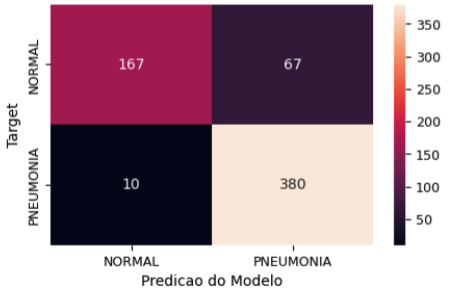

A seção 4.4 define o que é a **matriz de confusão** (imagem acima, figura 4, usada na seção 5), e indica o que é Verdadeiro Positivo (VP), Falso Positivo (FP), Verdadeiro negativo (VN) e Falso Negativo (FN), que são os números da matriz. A seção também define que a formula da da **sensibilidade** é `VP / (VP + FN)`, e que a fórmula da **especificidade** é `VN / (VN + FP)`. Portanto:

```
VP (target "PNEUMONIA", predição do modelo "PNEUMONIA") = 380
FP (target "NORMAL", predição do modelo "PNEUMONIA") = 67
VN (target "NORMAL", predição do modelo "NORMAL") = 167
FN (target "PNEUMONIA", predição do modelo "NORMAL") = 10

Sensibilidade = VP / (VP + FN) = 380 / (380 + 10) = 0.97 = 97%
Especificidade = VN / (VN + FP) = 167 / (167 + 67) = 0.71 = 71%
```